In [1]:
pip install pmdarima

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [3]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import plotly.express as px
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation

np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/DMA_225.csv")
data['Date-time'] = pd.to_datetime(data['Date-time'], dayfirst=True, errors='coerce')
data.rename( columns={'Flow':'DMA_225','Date-time':'Date_time'}, inplace=True )
data_DMA225 = data[['Date_time','DMA_225']]

In [6]:
data_DMA225[data_DMA225['DMA_225'].isnull()]

,Date_time,DMA_225
597,2016-04-07 05:15:00,NaN
598,2016-04-07 05:30:00,NaN
26283,2016-12-30 18:45:00,NaN
26284,2016-12-30 19:00:00,NaN
34468,2017-03-26 01:00:00,NaN
34469,2017-03-26 01:15:00,NaN
34470,2017-03-26 01:30:00,NaN
34471,2017-03-26 01:45:00,NaN


In [7]:
data_DMA225.dropna(subset = ["DMA_225"], inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
data_DMA225_indexed = data_DMA225.set_index('Date_time')
# Making hourly data 
hourly_data = data_DMA225_indexed.resample('h').sum()
hourly_data.shape

(8760, 1)

In [9]:
hourly_data_index = hourly_data.reset_index()

In [10]:
from sklearn.ensemble import IsolationForest
model =  IsolationForest()
model.fit(hourly_data_index[['DMA_225']])

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [11]:
score=model.decision_function(hourly_data_index[['DMA_225']])

In [12]:
hourly_data_index['scores'] = score
hourly_data_index_final = hourly_data_index[hourly_data_index.scores >-0.25]
final_df = hourly_data_index_final[['Date_time','DMA_225']]

In [13]:
hourly_data_index_final.shape

(8675, 3)

In [14]:
final_df.shape

(8675, 2)

In [15]:
figure = px.line(final_df,x="Date_time",y="DMA_225",title="DMA_225 with slider")
figure.update_xaxes(rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="12m",
                     step="month",
                     stepmode="backward"),
                dict(count=2,
                     label="8m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="4m",
                     step="month",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        )
    )
figure.show()

In [16]:
#Statistical information
final_df.describe()

,DMA_225
count,8675.000000
mean,14.048228
std,7.327960
min,0.000000
25%,8.000000
50%,13.777000
75%,19.223000
max,42.333000


In [17]:
final_df.shape

(8675, 2)

In [18]:
final_df1 = final_df.set_index('Date_time')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss

In [19]:
# Augmented Dickey-Fuller test
#Null Hypothesis (H0): If failed to be rejected, meaning it is non-stationary. It has some time dependent structure.
#Alternate Hypothesis (H1): The null hypothesis is rejected;  meaning it is stationary. It does not have time-dependent structure.

ADF_Check_Stationary = adfuller(final_df1)
print('ADF Statistic: %f' % ADF_Check_Stationary[0])
print('p-value: %f' % ADF_Check_Stationary[1])
print('Critical Values:')
for key, value in ADF_Check_Stationary[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.561747
p-value: 0.006536
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Observation :

1.The ADF statistic value of -3.5. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

2.p value - 0.006536 < 0.05 ; Data is stationary

In [20]:
#Kwiatkowski-Phillips-Schmidt-Shin test
#Null Hypothesis (H0): stationary.
#Alternate Hypothesis (H1): non-stationary

KPSS_Check_Stationary = kpss(final_df1)
KPSS_Check_Stationary

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




(7.300231938817829,
 0.01,
 37,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

Observation : 1.The ADF statistic value of 7.3. The positive value is statistic, and hence we have a stationary dataset

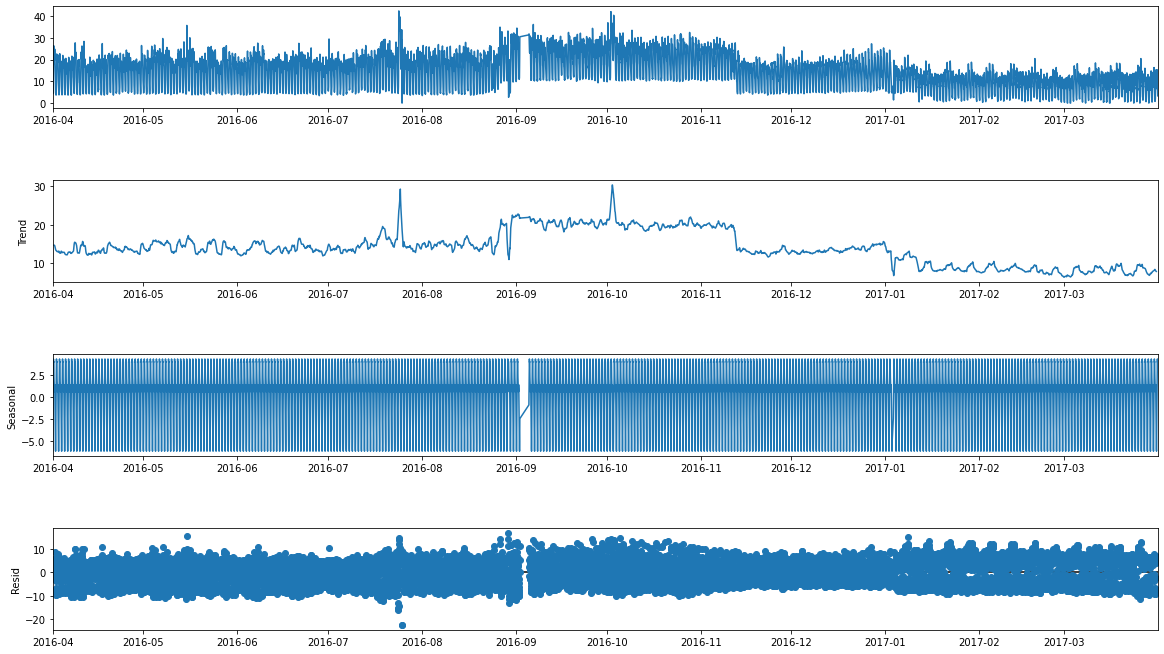

In [21]:
import statsmodels.api as sm
res=sm.tsa.seasonal_decompose(final_df1,period=24)
fig = res.plot()
fig.set_figheight(10)
fig.set_figwidth(18)
plt.show()

In [22]:
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [23]:
# Making a df
Original = final_df1["DMA_225"].to_frame().rename(columns = {"DMA_225": "Original" })
Forecast  = final_df1["DMA_225"].to_frame().shift(1).rename(columns = {"DMA_225": "Forecast" })
baseline = pd.concat([Original,Forecast],axis=1)
final = baseline[1:]#there is no prediction for first row due to shifting.
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(final.Original, final.Forecast))
rmse = round(rmse, 3)
print (" The root mean square value on dataset: ",rmse)

 The root mean square value on dataset:  2.757


<Figure size 1584x720 with 0 Axes>

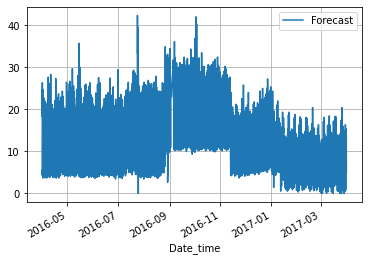

<Figure size 1584x720 with 0 Axes>

In [24]:
baseline_model = final[['Forecast']]
baseline_model.plot(grid=True)
plt.figure(figsize=(22,10))

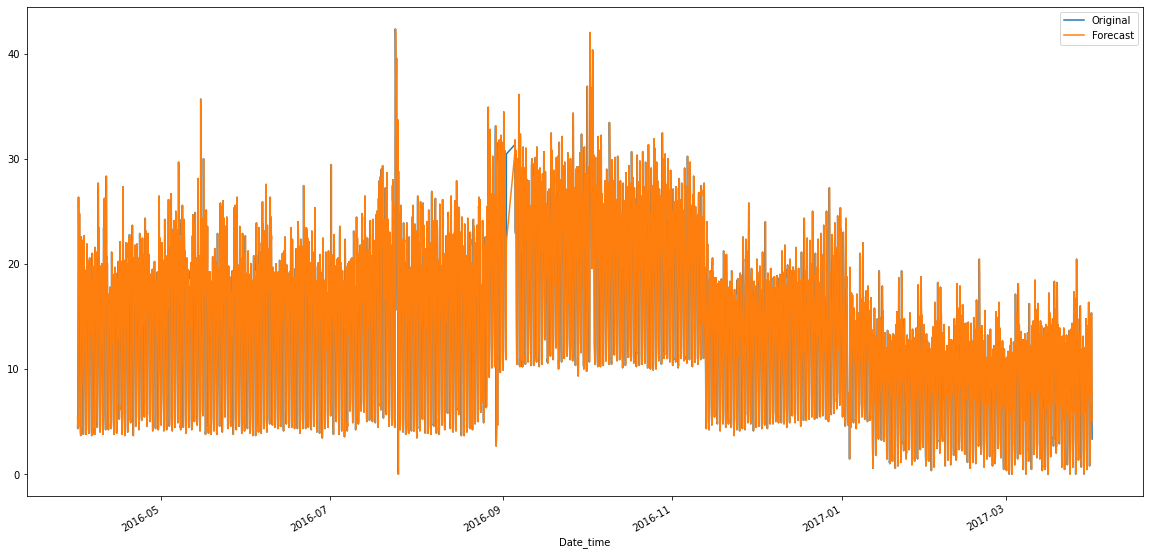

In [25]:
final.plot(figsize=(20,10))

In [26]:
final.iloc[-2603:]

,Original,Forecast
Date_time,,
2016-12-13 05:00:00,6.223,4.888
2016-12-13 06:00:00,8.889,6.223
2016-12-13 07:00:00,16.223,8.889
2016-12-13 08:00:00,20.444,16.223
2016-12-13 09:00:00,19.777,20.444
...,...,...
2017-03-31 19:00:00,10.888,13.223
2017-03-31 20:00:00,7.223,10.888
2017-03-31 21:00:00,7.222,7.223


 The root mean square value on dataset using baseline model:  2.117


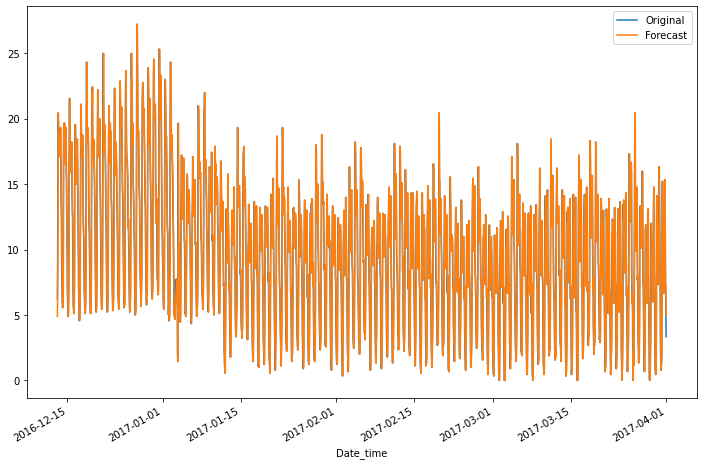

In [27]:
baseline_graph = final[-2603:]
rmse1 = np.sqrt(mean_squared_error(baseline_graph.Original, baseline_graph.Forecast))
rmse1 = round(rmse1, 3)
print (" The root mean square value on dataset using baseline model: ",rmse1)
baseline_graph.plot(figsize=(12,8))

# LSTM

In [28]:
# Split train data and test data
train_size = int(len(final_df1)*0.7)

#train_data = df.WC.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = final_df1.iloc[:train_size]
test_data = final_df1.iloc[train_size:]

In [29]:

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.fit_transform(test_data)

In [30]:
def data_preparation(array_dataset, look_back=1, future=1, index=0):
    features = array_dataset.shape[1]
    arr_X, arr_Y = [], []
    if len(array_dataset) - look_back <= 0:
        arr_X.append(array_dataset)
    else:
        for i in range(len(array_dataset) - look_back - future):
            arr_Y.append(array_dataset[(i + look_back):(i + look_back + future), index])
            arr_X.append(array_dataset[i:(i + look_back)])
    arr_X, arr_Y = np.array(arr_X), np.array(arr_Y)
    arr_X = np.reshape(arr_X, (arr_X.shape[0], look_back, features))
    return arr_X, arr_Y

look_back = 12
features = 1
X_train, Y_train = data_preparation(train_scaled, look_back=12, future=24, index=0)
X_test, Y_test = data_preparation(test_scaled, look_back=12, future=24, index=0)

In [31]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape( (X_test.shape[0],X_test.shape[1],1))

In [32]:
print('X_train shape:',X_train.shape)
print('Y_train shape:',Y_train.shape)
print('X_test shape:',X_test.shape)
print('Y_test shape:',Y_test.shape)

X_train shape: (6036, 12, 1)
Y_train shape: (6036, 24)
X_test shape: (2567, 12, 1)
Y_test shape: (2567, 24)


In [33]:
model2 = tf.keras.Sequential()
#model2.add(LSTM(40, return_sequences = True,input_shape=(look_back,features)))
model2.add(LSTM(40,input_shape=(look_back,features)))
model2.add(Dropout(0.7))
# model2.add(LSTM(30))
# model2.add(Dropout(0.35))
model2.add(Dense(24))
model2.compile(loss='mean_squared_error', optimizer='adam')
#history=model.fit(X_train1, Y_train1, validation_data=(X_test1,Y_test1),shuffle=False, epochs=100, batch_size=1, verbose=2)
history2=model2.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=50,batch_size=16)

Epoch 1/50
378/378 [==============================] - 5s 9ms/step - loss: 0.0509 - val_loss: 0.0257
Epoch 2/50
378/378 [==============================] - 3s 7ms/step - loss: 0.0246 - val_loss: 0.0204
Epoch 3/50
378/378 [==============================] - 3s 7ms/step - loss: 0.0198 - val_loss: 0.0187
Epoch 4/50
378/378 [==============================] - 3s 7ms/step - loss: 0.0177 - val_loss: 0.0180
Epoch 5/50
378/378 [==============================] - 3s 7ms/step - loss: 0.0163 - val_loss: 0.0171
Epoch 6/50
378/378 [==============================] - 3s 7ms/step - loss: 0.0156 - val_loss: 0.0164
Epoch 7/50
378/378 [==============================] - 3s 7ms/step - loss: 0.0150 - val_loss: 0.0167
Epoch 8/50
378/378 [==============================] - 3s 7ms/step - loss: 0.0145 - val_loss: 0.0148
Epoch 9/50
378/378 [==============================] - 3s 7ms/step - loss: 0.0141 - val_loss: 0.0149
Epoch 10/50
378/378 [==============================] - 3s 7ms/step - loss: 0.0135 - val_loss: 0.0147

In [34]:

# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history2.history['loss'])
    plt.plot(history2.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

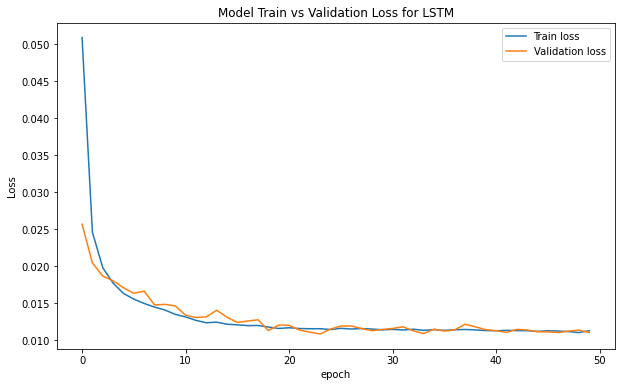

In [35]:
plot_loss(history2,'LSTM')

In [36]:
# Generate predictions
train_pred = model2.predict(X_train)
#evaluation = model.evaluate(x=X_test, y=y_test, verbose=1)
test_pred = model2.predict(X_test)

In [37]:
# # De-standardising the output to original value
# train_pred = scaler.inverse_transform(train_pred)
# #y_train = scaler.inverse_transform([Y_train])
# test_pred = scaler.inverse_transform(test_pred)
# y_test = scaler.inverse_transform([Y_test])
predictions = test_pred

In [38]:
final_df2= final_df1.reset_index()


In [39]:
predictions.shape

(2567, 24)

In [40]:
Y_test.shape

(2567, 24)

In [41]:
# To make a dataframe of original and predicted value:
lstm_df=[]
for i in range (0, len(predictions)):
  lstm_df.append((predictions[i][0]))
#final_df = pd.DataFrame((y_test[0]))
final_data = pd.DataFrame((Y_test))
final_data.rename(columns = {0:'original_value'}, inplace = True)
final_data['predicted_value'] = lstm_df

In [43]:
import math
from sklearn.metrics import mean_squared_error
testset = math.sqrt(mean_squared_error(final_data['original_value'], final_data['predicted_value']))
print("The RMSE prediction value on testset: ",testset)

The RMSE prediction value on testset:  0.08075397715745028


In [49]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model2.predict(X_test)]
y = [y[0] for y in Y_test]
# Creating the frame to store both predictions
days = final_df2[['Date_time']].values[-len(y):]
df = pd.DataFrame(days,columns = ['Date_time'])
result = pd.concat([df, final_data], axis=1, join='inner')
result.shape

(2567, 26)

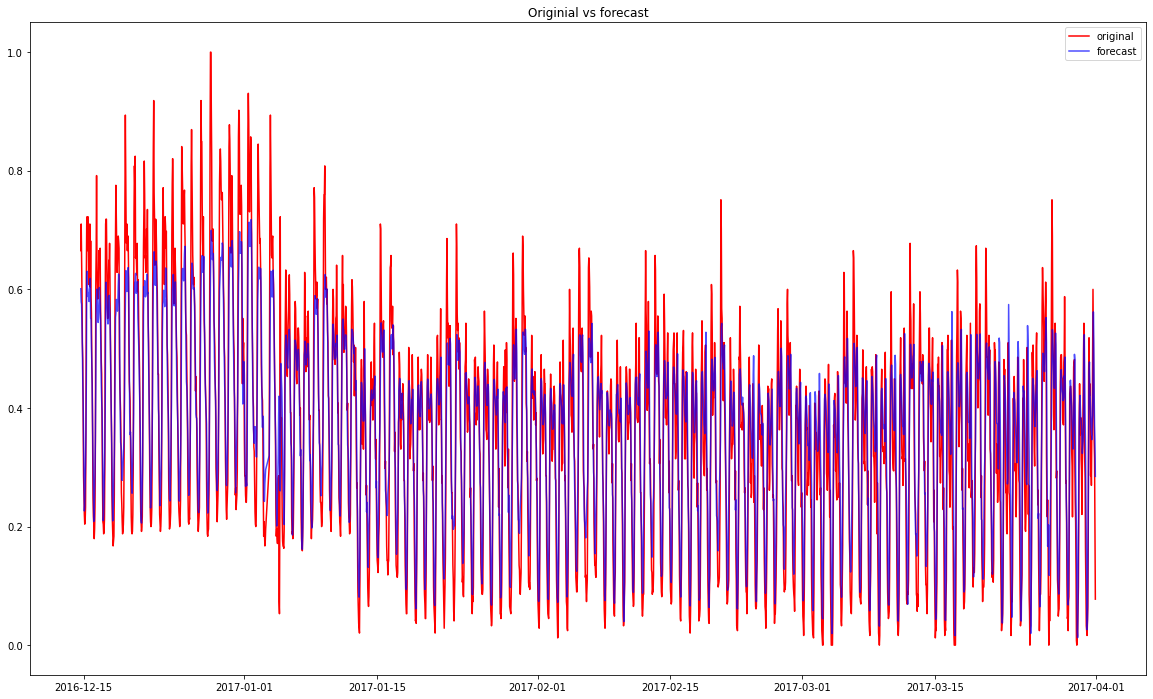

In [50]:
# Plotting original and predicted graph:
plt.figure(figsize=(20, 12))
plt.plot(result.Date_time, result.original_value, color='red', label='original')
plt.plot(result.Date_time, result.predicted_value, color='blue', label='forecast', alpha=0.7)
plt.title('Originial vs forecast')
plt.legend()
plt.show()

In [51]:
df.to_csv('raw_data.csv', index=False)
df.to_excel('raw_data.xls', index=False)

In [53]:
from google.colab import files

# e.g. save pandas output as csv
result.to_csv('DMA_225_ULSTM_hp.csv')

# or any other file as usual
# with open('example.csv', 'w') as f:
#   f.write('your strings here')

files.download('DMA_225_ULSTM_hp.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>